In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import coint
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy.linalg as la


In [2]:
file_path = r"C:\Users\86136\Desktop\Individual Assignment Data File .xlsx"

# Q6

In [ ]:
# ---------------------------
# 1. Expected returns (from your table)
# ---------------------------
expected_returns = np.array([
    0.029291156,  # B1
    0.050857372,  # B2
    0.05813191,   # B3
    0.062901451   # B4
])

# ---------------------------
# 2. Covariance matrix (from your image)
# ---------------------------
cov_matrix = np.array([
    [9.91903E-05,  1.22818E-06, -1.42818E-06, -5.42223E-06],
    [1.22818E-06,  0.000108673, -6.93255E-06, -4.13352E-06],
    [-1.42818E-06, -6.93255E-06, 0.000114334, 9.24741E-06],
    [-5.42223E-06, -4.13352E-06, 9.24741E-06, 0.000112918]
])

# ---------------------------
# 3. Mean-variance optimization (Maximum Sharpe Ratio)
# ---------------------------
inv_cov = np.linalg.pinv(cov_matrix)
w_raw = inv_cov @ expected_returns
optimal_weights = w_raw / w_raw.sum()

# ---------------------------
# 4. Print results
# ---------------------------
bond_labels = ['B1', 'B2', 'B3', 'B4']
for bond, w in zip(bond_labels, optimal_weights):
    print(f"{bond}: {w:.4%}")


B1: 17.2283%
B2: 27.3111%
B3: 26.3721%
B4: 29.0885%


# Q7

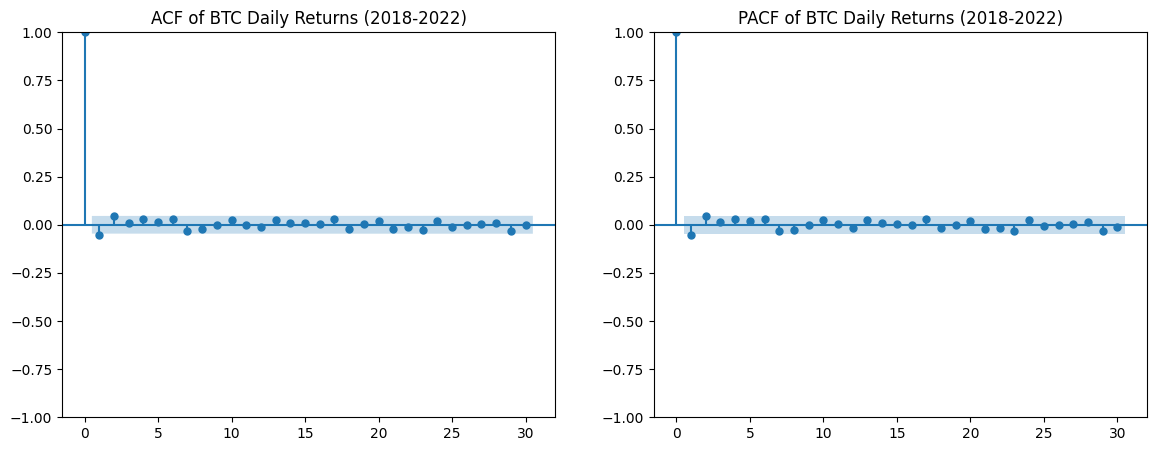

In [4]:
# Q7
# Import data from Cryptos worksheet
cryptos_data = pd.read_excel(file_path, sheet_name='Cryptos')

warnings.filterwarnings("ignore")

# =====================================================
# Question 7: Generate ACF and PACF plots, and explain
# =====================================================
# 1. Filter BTC daily price data for 2018-2022, and set date index
btc_data = cryptos_data[['Date', 'BTC']].copy()
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data = btc_data.set_index('Date')
btc_data = btc_data.loc['2018-01-01':'2022-12-31']

# 2. Calculate daily log returns: log_return = ln(P_t) - ln(P_{t-1})
btc_data['log_return'] = np.log(btc_data['BTC']).diff()
btc_returns = btc_data['log_return'].dropna()

# 3. Plot ACF and PACF charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(btc_returns, lags=30, ax=axes[0])
axes[0].set_title('ACF of BTC Daily Returns (2018-2022)')
plot_pacf(btc_returns, lags=30, ax=axes[1])
axes[1].set_title('PACF of BTC Daily Returns (2018-2022)')
plt.show()

# Q8

In [5]:
# Q8 Judge (without using logarithm)  
cryptos_data = pd.read_excel(file_path, sheet_name='Cryptos')
cryptos_data.columns = ['Date', 'BTC', 'ETH']
cryptos_data['Date'] = pd.to_datetime(cryptos_data['Date'])
cryptos_data.set_index('Date', inplace=True)

# Filter data from 2018-01-01 to 2022-12-31
data = cryptos_data.loc['2018-01-01':'2022-12-31'].copy()

# Q8 - ARIMA Modeling
# =====================================================
# Prepare BTC return data for ARIMA modeling
# =====================================================
btc_price = data['BTC']
btc_returns = btc_price.pct_change().dropna()  # Use percentage returns

# ARIMA model selection: Fix d=0, search for optimal (p,q) combination
aic_results = []
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = ARIMA(btc_returns, order=(p, 0, q))
            res = model.fit()
            aic_results.append({'p': p, 'd': 0, 'q': q, 'AIC': res.aic})
            print(f"Test ARIMA({p},0,{q}): AIC = {res.aic:.4f}")
        except Exception as e:
            print(f"ARIMA({p},0,{q}) failed:", e)
 
results_df = pd.DataFrame(aic_results)
best_model = results_df.loc[results_df['AIC'].idxmin()]

print("\nOptimal ARIMA Model Selection:")
print(best_model)

Test ARIMA(1,0,1): AIC = -6712.2575
Test ARIMA(1,0,2): AIC = -6711.6332
Test ARIMA(1,0,3): AIC = -6709.4625
Test ARIMA(2,0,1): AIC = -6711.7636
Test ARIMA(2,0,2): AIC = -6709.2458
Test ARIMA(2,0,3): AIC = -6708.9844
Test ARIMA(3,0,1): AIC = -6709.4865
Test ARIMA(3,0,2): AIC = -6707.4092
Test ARIMA(3,0,3): AIC = -6708.0079

Optimal ARIMA Model Selection:
p         1.000000
d         0.000000
q         1.000000
AIC   -6712.257482
Name: 0, dtype: float64


# Q9

=== Strategy Results (Simple Return Version) ===
   Year      Mean       Std       Min       Max  Count  YearlyCumRet
0  2019  0.070991  0.162738 -0.082134  0.389469   12.0      1.025355
1  2020  0.084037  0.132997 -0.071436  0.333810   12.0      1.434535
2  2021  0.062840  0.109821 -0.061073  0.363088   12.0      0.969743
3  2022 -0.041838  0.123724 -0.233223  0.188752   12.0     -0.454482
4  2023  0.036058  0.060069 -0.063940  0.128654   12.0      0.501317
5  2024  0.043482  0.105759 -0.070630  0.259379   12.0      0.579529


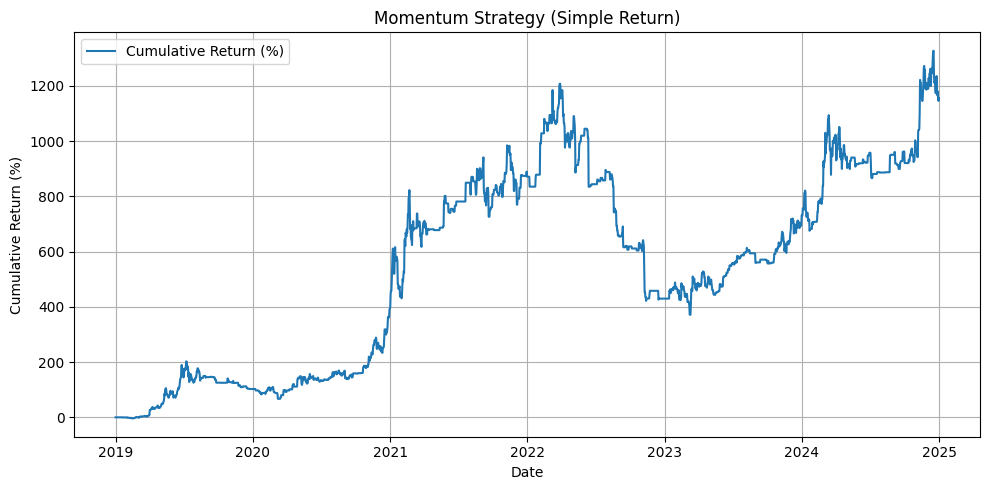

In [6]:
#  Q9 Simple Returns
df = pd.read_excel(file_path, sheet_name='Cryptos')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df['return'] = df['BTC'].pct_change()
df.dropna(subset=['return'], inplace=True)
df.reset_index(drop=True, inplace=True)

# 2. AR(2) model prediction function (manual OLS)
def forecast_ar2(returns_60):
    r = np.array(returns_60)
    y = r[2:]
    X = np.column_stack([np.ones(len(y)), r[1:-1], r[:-2]])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]
    return coef[0] + coef[1]*r[-1] + coef[2]*r[-2]

# 3. Calculate strategy returns (using simple returns)
df['StrategyReturn'] = 0.0
df['Forecast'] = np.nan
df['Avg360'] = np.nan

for i in range(360, len(df)):
    date_i = df.loc[i, 'Date']
    year_i = date_i.year
    if year_i < 2019 or year_i > 2024:
        continue
    
    window_60 = df.loc[i-60:i-1, 'return'].values
    window_360 = df.loc[i-360:i-1, 'return'].values
    if len(window_60) < 60 or len(window_360) < 360:
        continue
    
    fcast = forecast_ar2(window_60)
    r_bar = window_360.mean()
    threshold = max(0, r_bar)
    
    df.at[i, 'Forecast'] = fcast
    df.at[i, 'Avg360'] = r_bar
    
    if fcast > threshold:
        df.at[i, 'StrategyReturn'] = df.loc[i, 'return']
    else:
        df.at[i, 'StrategyReturn'] = 0.0

# 4. Aggregate to monthly returns (compound)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df_strategy = df[(df['Year'] >= 2019) & (df['Year'] <= 2024)].copy()

# Monthly returns: compound
monthly_returns = df_strategy.groupby(df_strategy['Date'].dt.to_period('M'))['StrategyReturn'].apply(
    lambda x: (1 + x).prod() - 1 ).reset_index()
monthly_returns.columns = ['YearMonth', 'MonthlyReturn']
monthly_returns['Year'] = monthly_returns['YearMonth'].dt.year
monthly_returns['Month'] = monthly_returns['YearMonth'].dt.month

# Annual statistics
def summary_stats(group):
    return pd.Series({
        'Mean': group['MonthlyReturn'].mean(),
        'Std': group['MonthlyReturn'].std(),
        'Min': group['MonthlyReturn'].min(),
        'Max': group['MonthlyReturn'].max(),
        'Count': len(group)
    })

yearly_stats = monthly_returns.groupby('Year').apply(summary_stats).reset_index()

# Annual cumulative return
yearly_cum = monthly_returns.groupby('Year')['MonthlyReturn'].apply(
    lambda x: (1 + x).prod() - 1 ).rename('YearlyCumRet').reset_index()

yearly_stats = pd.merge(yearly_stats, yearly_cum, on='Year', how='left')

print("=== Strategy Results (Simple Return Version) ===")
print(yearly_stats)

# 5. Strategy cumulative return curve
df_strategy['CumulativeReturn'] = (1 + df_strategy['StrategyReturn']).cumprod() - 1

plt.figure(figsize=(10, 5))
plt.plot(df_strategy['Date'], df_strategy['CumulativeReturn'] * 100, label='Cumulative Return (%)')
plt.title("Momentum Strategy (Simple Return)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Q10

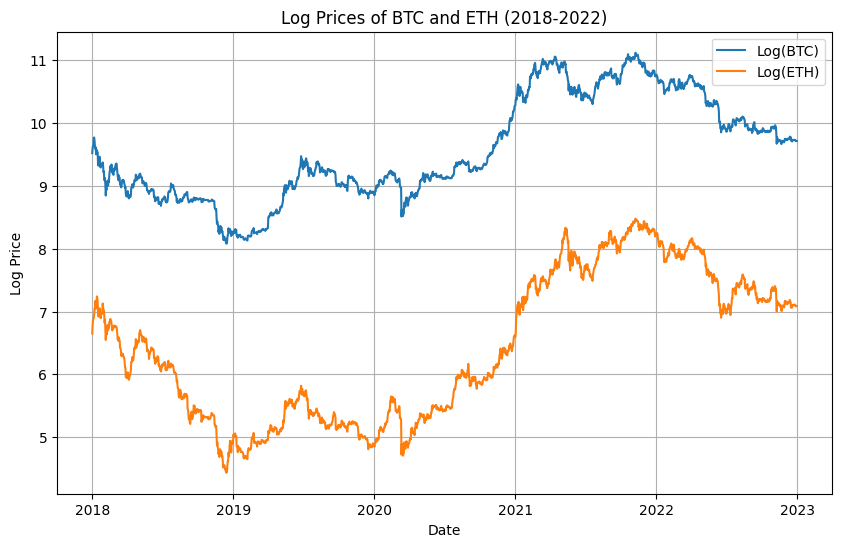


--- Johansen Test: det_order=0, k_ar_diff=1 ---
Rank = 0: Trace Stat = 15.9321 | Critical Values (90%, 95%, 99%) = [13.4294 15.4943 19.9349]
Rank = 1: Trace Stat = 3.9771 | Critical Values (90%, 95%, 99%) = [2.7055 3.8415 6.6349]
Cointegration relationship exists (passed 95% significance test)

--- Johansen Test: det_order=0, k_ar_diff=2 ---
Rank = 0: Trace Stat = 15.5124 | Critical Values (90%, 95%, 99%) = [13.4294 15.4943 19.9349]
Rank = 1: Trace Stat = 3.8972 | Critical Values (90%, 95%, 99%) = [2.7055 3.8415 6.6349]
Cointegration relationship exists (passed 95% significance test)

--- Johansen Test: det_order=1, k_ar_diff=1 ---
Rank = 0: Trace Stat = 16.5037 | Critical Values (90%, 95%, 99%) = [16.1619 18.3985 23.1485]
Rank = 1: Trace Stat = 5.5377 | Critical Values (90%, 95%, 99%) = [2.7055 3.8415 6.6349]
No significant cointegration relationship

--- Johansen Test: det_order=1, k_ar_diff=2 ---
Rank = 0: Trace Stat = 15.9540 | Critical Values (90%, 95%, 99%) = [16.1619 18.3985 23

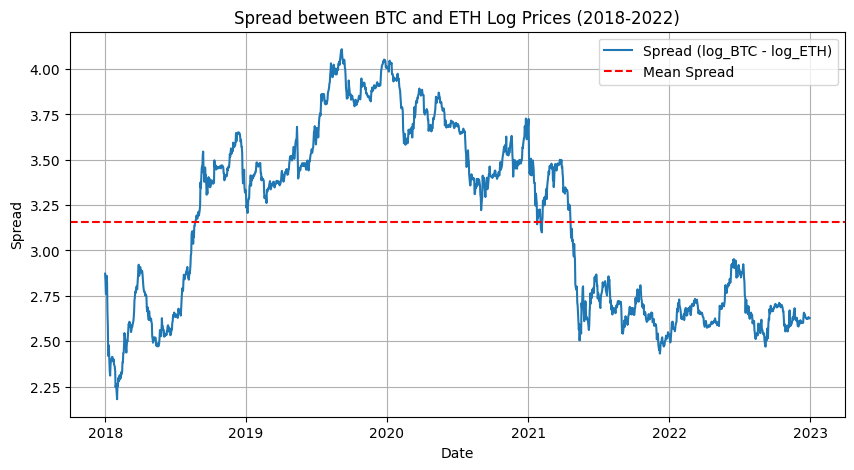

In [7]:
# Q10
# 1. Filter data from 2018-01-01 to 2022-12-31
data = cryptos_data.loc['2018-01-01':'2022-12-31'].copy()

# 2. Calculate log prices
data['log_BTC'] = np.log(data['BTC'])
data['log_ETH'] = np.log(data['ETH'])

# Plot log price trends
plt.figure(figsize=(10,6))
plt.plot(data.index, data['log_BTC'], label='Log(BTC)')
plt.plot(data.index, data['log_ETH'], label='Log(ETH)')
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.title("Log Prices of BTC and ETH (2018-2022)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Multi-angle Johansen cointegration test (try different det_order and k_ar_diff)
log_prices = data[['log_BTC', 'log_ETH']].dropna()
det_orders = [0, 1]
k_ar_diffs = [1, 2]

for det in det_orders:
    for k_ar in k_ar_diffs:
        print(f"\n--- Johansen Test: det_order={det}, k_ar_diff={k_ar} ---")
        result = coint_johansen(log_prices, det_order=det, k_ar_diff=k_ar)
        
        trace_stat = result.lr1
        crit_values = result.cvt
        
        for i in range(len(trace_stat)):
            print(f"Rank = {i}: Trace Stat = {trace_stat[i]:.4f} | Critical Values (90%, 95%, 99%) = {crit_values[i]}")
        
        if trace_stat[0] > crit_values[0, 1]:
            print("Cointegration relationship exists (passed 95% significance test)")
        else:
            print("No significant cointegration relationship")

# 4. Calculate log price correlation coefficient
corr_log = np.corrcoef(data['log_BTC'], data['log_ETH'])[0, 1]
print(f"\nCorrelation (Log Prices) between BTC and ETH: {corr_log:.4f}")

# 5. Calculate log spread and visualize
data['spread'] = data['log_BTC'] - data['log_ETH']
mean_spread = data['spread'].mean()

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['spread'], label='Spread (log_BTC - log_ETH)')
plt.axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread between BTC and ETH Log Prices (2018-2022)')
plt.legend()
plt.grid(True)
plt.show()

# Q11

Estimated alpha (hedge coefficient): 15.2914


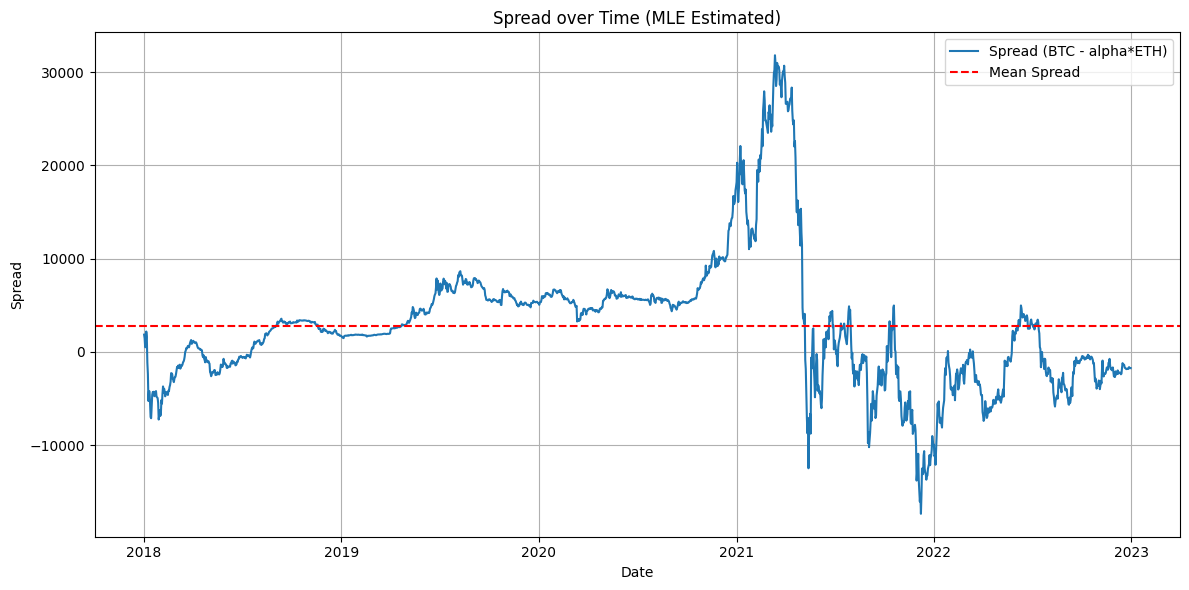

In [8]:
# Q11
# ----------------------------- 
# 1. Get price data from 2018-01-01 to 2022-12-31
# ----------------------------- 
df = cryptos_data.loc['2018-01-01':'2022-12-31'].copy()

# 2. Prepare regression variables
#    - y: BTC price
#    - X: ETH price (without constant, model: BTC = alpha * ETH + epsilon)
y = df['BTC']
X = df['ETH']

# ----------------------------- 
# 3. Define negative log-likelihood function
# ----------------------------- 
def neg_log_likelihood(params, y, X):
    alpha, sigma = params
    if sigma <= 0:
        return np.inf
    residuals = y - alpha * X
    n = len(y)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - n * np.log(sigma) - 0.5 * np.sum((residuals / sigma) ** 2)
    return -log_likelihood  # Return negative log-likelihood

# ----------------------------- 
# 4. Estimate parameters using MLE
# ----------------------------- 
init_params = [1.0, 1.0]
result = minimize(neg_log_likelihood, init_params, args=(y, X), method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])
alpha_mle, sigma_mle = result.x

# ----------------------------- 
# 5. Output regression results summary
# ----------------------------- 
print(f"Estimated alpha (hedge coefficient): {alpha_mle:.4f}")

# ----------------------------- 
# 6. Construct spread series: Spread_t = BTC_t - alpha * ETH_t
# ----------------------------- 
df['Spread'] = y - alpha_mle * X

# ----------------------------- 
# 7. Visualization
# ----------------------------- 
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Spread'], label='Spread (BTC - alpha*ETH)')
plt.axhline(df['Spread'].mean(), color='red', linestyle='--', label='Mean Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Spread over Time (MLE Estimated)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Q12


===== Annual Summary of Monthly Returns =====
          mean       std       min       max  count
Date                                               
2019 -0.028577  0.059261 -0.149909  0.028916     12
2020 -0.018675  0.078619 -0.209673  0.065715     12
2021 -0.000801  0.076893 -0.119683  0.107786     12
2022  0.005274  0.027244 -0.029351  0.080718     12
2023 -0.004447  0.034018 -0.097068  0.035875     12
2024 -0.018156  0.036799 -0.077270  0.036415     12


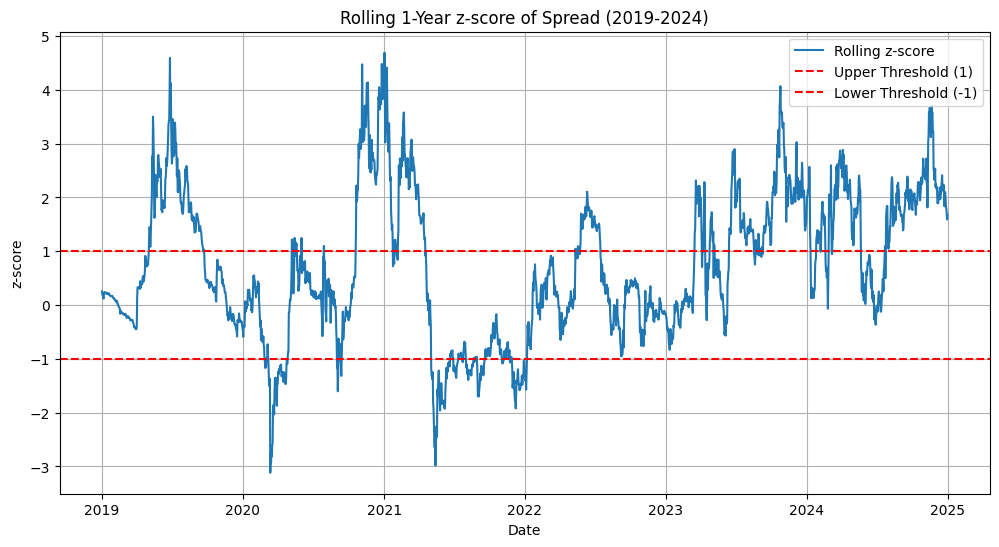

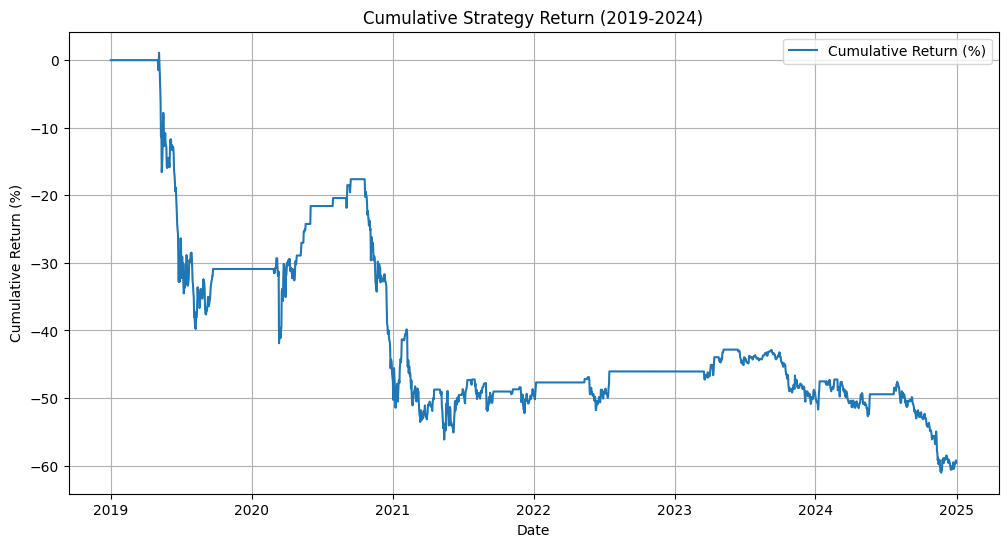

In [9]:
# Q12
# First select data from 2018-01-01 to 2024-12-31 for rolling window calculation
df = cryptos_data.loc['2018-01-01':'2024-12-31'].copy()

# =======================
# 2. Construct Spread + Dynamic Rolling Statistics
# =======================
# Assume hedge coefficient alpha from Q11
alpha = 15.2915

# Spread = BTC - alpha * ETH
df['Spread'] = df['BTC'] - alpha * df['ETH']

# Set rolling window: 252 trading days ~ 1 year
window_size = 252
min_periods = int(window_size / 2)  # At least half of the data

# Calculate rolling mean and standard deviation
df['RollingMean'] = df['Spread'].rolling(window=window_size, min_periods=min_periods).mean()
df['RollingStd'] = df['Spread'].rolling(window=window_size, min_periods=min_periods).std()

# Dynamic z-score
df['zscore'] = (df['Spread'] - df['RollingMean']) / df['RollingStd']

# =======================
# 3. Only trade within the 2019-2024 period
# =======================
data = df.loc['2019-01-01':'2024-12-31'].copy()

# =======================
# 4. Generate trading signals (yesterday's z-score determines today's position)
# =======================
def get_signal(z):
    if z < -1:
        return 1   # Long spread (long BTC, short ETH)
    elif z > 1:
        return -1  # Short spread (short BTC, long ETH)
    else:
        return 0

data['signal'] = data['zscore'].shift(1).apply(get_signal).fillna(0)

# =======================
# 5. Calculate nominal position and daily returns
# =======================
# Nominal position (Nominal) = |BTC| + alpha*|ETH|, represents portfolio size
data['Nominal'] = data['BTC'].abs() + alpha * data['ETH'].abs()
data['Nominal_shift'] = data['Nominal'].shift(1)

# Daily spread change
data['Spread_diff'] = data['Spread'].diff()

# Daily P&L = yesterday's signal * today's Spread_diff
data['DailyPnL'] = data['signal'] * data['Spread_diff'].fillna(0)

# Daily return = Daily P&L / yesterday's nominal position
data['DailyReturn'] = data['DailyPnL'] / data['Nominal_shift']
data['DailyReturn'] = data['DailyReturn'].fillna(0)

# =======================
# 6. Aggregate to monthly returns + annual statistics
# =======================
# Calculate monthly returns using compound return formula
def monthly_return_func(subseries):
    return (1 + subseries).prod() - 1

monthly_returns = data['DailyReturn'].resample('M').apply(monthly_return_func)

# Statistics for each year's monthly returns: mean, std, min, max, count
summary_by_year = monthly_returns.groupby(monthly_returns.index.year).agg(['mean','std','min','max','count'])
 
print("\n===== Annual Summary of Monthly Returns =====")
print(summary_by_year)

# =======================
# 7. Visualization
# =======================
# (a) Plot rolling window z-score
plt.figure(figsize=(12,6))
plt.plot(data.index, data['zscore'], label='Rolling z-score')
plt.axhline(1, color='red', linestyle='--', label='Upper Threshold (1)')
plt.axhline(-1, color='red', linestyle='--', label='Lower Threshold (-1)')
plt.title("Rolling 1-Year z-score of Spread (2019-2024)")
plt.xlabel("Date")
plt.ylabel("z-score")
plt.legend()
plt.grid(True)
plt.show()

# (b) Plot cumulative strategy return curve (based on daily returns)
data['CumulativeReturn'] = (1 + data['DailyReturn']).cumprod() - 1
plt.figure(figsize=(12,6))
plt.plot(data.index, data['CumulativeReturn']*100, label='Cumulative Return (%)')
plt.title("Cumulative Strategy Return (2019-2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.show()

# Q15

=== Merged Asset Data (First Few Rows) ===
                VGK       VOO       USO       GLD       IYR      GBTC  \
YearMonth                                                               
2018-01    0.056298  0.055852  0.080766  0.032349 -0.030243 -0.296285   
2018-02   -0.061460 -0.037260 -0.046995 -0.020760 -0.066573  0.143682   
2018-03   -0.003615 -0.024771  0.058205  0.006320  0.037614 -0.411666   
2018-04    0.021496  0.003470  0.054240 -0.009540  0.002253  0.510963   
2018-05   -0.024242  0.024164 -0.018116 -0.011959  0.033712 -0.225237   

           Momentum  StatArb  
YearMonth                     
2018-01         0.0      0.0  
2018-02         0.0      0.0  
2018-03         0.0      0.0  
2018-04         0.0      0.0  
2018-05         0.0      0.0  

In-sample data: 48 rows
Out-of-sample data: 24 rows

=== P0 Optimal Weights (ETFs Only) ===
VGK: -1.2169
VOO: 1.9789
USO: 0.2019
GLD: 0.7718
IYR: -0.7808
GBTC: 0.0452

=== P1 Optimal Weights (ETFs + Strategies) ===
VGK: -1.4193

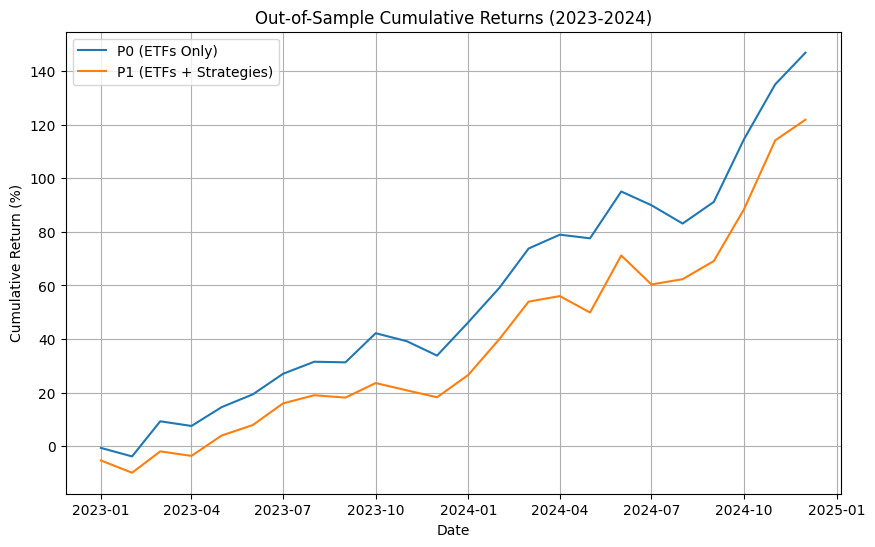


P0: Average Monthly Return = 3.97%, Volatility = 5.45%, Sharpe Ratio = 0.73
P1: Average Monthly Return = 3.55%, Volatility = 6.15%, Sharpe Ratio = 0.58

P0: Final Cumulative Return = 146.92%
P1: Final Cumulative Return = 121.91%

In P1 portfolio, trading strategies total weight: 19.32%
Momentum strategy: 32.25%
Statistical arbitrage strategy: -12.93%


In [10]:
# Question 15
# ======== 1. Prepare Monthly Returns Data for Momentum Strategy ========
# Calculate momentum strategy returns from raw data
# Load cryptocurrency data
crypto_data = pd.read_excel(file_path, sheet_name='Cryptos')
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'])
crypto_data.set_index('Date', inplace=True)

# Calculate BTC simple returns
crypto_data['BTC_Return'] = crypto_data['BTC'].pct_change()
crypto_data.dropna(subset=['BTC_Return'], inplace=True)

# Define AR(2) forecast function
def forecast_ar2(returns_60):
    r = np.array(returns_60)
    y = r[2:]
    X = np.column_stack([np.ones(len(y)), r[1:-1], r[:-2]])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]
    return coef[0] + coef[1]*r[-1] + coef[2]*r[-2]

# Implement momentum strategy
crypto_data['Strategy_Return'] = 0.0
crypto_data['Forecast'] = np.nan
crypto_data['Avg360'] = np.nan

for i in range(len(crypto_data)):
    # Skip if data is less than 360 days
    if i < 360:
        continue
   
    # Get past 60-day and 360-day data
    window_60 = crypto_data['BTC_Return'].iloc[i-60:i].values
    window_360 = crypto_data['BTC_Return'].iloc[i-360:i].values
   
    if len(window_60) < 60 or len(window_360) < 360:
        continue
   
    # AR(2) forecast
    fcast = forecast_ar2(window_60)
    crypto_data.iloc[i, crypto_data.columns.get_loc('Forecast')] = fcast
   
    # Calculate 360-day average return
    avg_360 = np.mean(window_360)
    crypto_data.iloc[i, crypto_data.columns.get_loc('Avg360')] = avg_360
   
    # Strategy decision
    threshold = max(0, avg_360)
    if fcast > threshold:
        crypto_data.iloc[i, crypto_data.columns.get_loc('Strategy_Return')] = crypto_data['BTC_Return'].iloc[i]

# Aggregate daily returns to monthly returns
crypto_data['Year'] = crypto_data.index.year
crypto_data['Month'] = crypto_data.index.month
crypto_data['YearMonth'] = pd.PeriodIndex(crypto_data.index, freq='M')

# Calculate monthly returns (compound)
monthly_momentum = crypto_data.groupby('YearMonth')['Strategy_Return'].apply(
    lambda x: (1 + x).prod() - 1 if len(x) > 0 else 0
).to_frame(name='Momentum')

# ======== 2. Prepare Monthly Returns Data for Statistical Arbitrage Strategy ========
# First select data from 2018-01-01 to 2024-12-31 for rolling window calculation
df = crypto_data.loc['2018-01-01':'2024-12-31'].copy()

# ======================= 
# 2. Construct Spread + Dynamic Rolling Statistics
# =======================
# Assume hedge coefficient alpha from Q11
alpha = 15.2915

# Spread = BTC - alpha * ETH
df['Spread'] = df['BTC'] - alpha * df['ETH']

# Set rolling window: 252 trading days ~ 1 year
window_size = 252
min_periods = int(window_size / 2)  # At least half of the data

# Calculate rolling mean and standard deviation
df['RollingMean'] = df['Spread'].rolling(window=window_size, min_periods=min_periods).mean()
df['RollingStd'] = df['Spread'].rolling(window=window_size, min_periods=min_periods).std()

# Dynamic z-score
df['zscore'] = (df['Spread'] - df['RollingMean']) / df['RollingStd']

# =======================
# 3. Only trade within the 2019-2024 period
# =======================
data = df.loc['2019-01-01':'2024-12-31'].copy()

# =======================
# 4. Generate trading signals (yesterday's z-score determines today's position)
# =======================
def get_signal(z):
    if z < -1:
        return 1   # Long spread (long BTC, short ETH)
    elif z > 1:
        return -1  # Short spread (short BTC, long ETH)
    else:
        return 0

data['signal'] = data['zscore'].shift(1).apply(get_signal).fillna(0)

# =======================
# 5. Calculate nominal position and daily returns
# =======================
# Nominal position (Nominal) = |BTC| + alpha*|ETH|, represents portfolio size
data['Nominal'] = data['BTC'].abs() + alpha * data['ETH'].abs()
data['Nominal_shift'] = data['Nominal'].shift(1)

# Daily spread change
data['Spread_diff'] = data['Spread'].diff()

# Daily P&L = yesterday's signal * today's Spread_diff
data['DailyPnL'] = data['signal'] * data['Spread_diff'].fillna(0)

# Daily return = Daily P&L / yesterday's nominal position
data['DailyReturn'] = data['DailyPnL'] / data['Nominal_shift']
data['DailyReturn'] = data['DailyReturn'].fillna(0)

# =======================
# 6. Aggregate to monthly returns + annual statistics
# =======================
# Calculate monthly returns using compound return formula
def monthly_return_func(subseries):
    return (1 + subseries).prod() - 1

# Calculate monthly returns and ensure compatibility with original code format
data['Year'] = data.index.year
data['Month'] = data.index.month
data['YearMonth'] = pd.PeriodIndex(data.index, freq='M')

# Calculate monthly returns and create DataFrame
monthly_statarb = data.groupby('YearMonth')['DailyReturn'].apply(monthly_return_func).to_frame(name='StatArb')

# ======== 3. Load ETF Monthly Returns Data ========
etfs_df = pd.read_excel(file_path, sheet_name="ETFs")
etfs_df['Date'] = pd.to_datetime(etfs_df['Date'])
# Convert date to Period index
etfs_df['YearMonth'] = pd.PeriodIndex(etfs_df['Date'], freq='M')
etfs_df.set_index('YearMonth', inplace=True)
etfs_df.drop(columns=['Date'], inplace=True)

# ETF column names
etf_cols = ['VGK', 'VOO', 'USO', 'GLD', 'IYR', 'GBTC']

# ======== 4. Merge ETF and Strategy Monthly Returns Data ========
# Align and merge by month period
full_df = etfs_df[etf_cols].join(monthly_momentum, how='left').join(monthly_statarb, how='left')
full_df.sort_index(inplace=True)
# Handle missing values
full_df = full_df.fillna(0)

# Display merged data
print("=== Merged Asset Data (First Few Rows) ===")
print(full_df.head())

# ======== 5. Split In-Sample and Out-of-Sample Periods ========
# In-sample: 2019-01 to 2022-12; Out-of-sample: 2023-01 to 2024-12
in_sample = full_df.loc['2019-01':'2022-12'].copy()
out_sample = full_df.loc['2023-01':'2024-12'].copy()

print(f"\nIn-sample data: {len(in_sample)} rows")
print(f"Out-of-sample data: {len(out_sample)} rows")

# ======== 6. Construct Portfolios ============
# P0: ETFs only
# P1: 6 ETFs plus two strategies (Momentum and Statistical Arbitrage)
assets_P0 = etf_cols
assets_P1 = etf_cols + ['Momentum', 'StatArb']

# 6.1 Calculate mean and covariance matrix for each portfolio using in-sample data
mu_P0 = in_sample[assets_P0].mean()
cov_P0 = in_sample[assets_P0].cov()

mu_P1 = in_sample[assets_P1].mean()
cov_P1 = in_sample[assets_P1].cov()

# 6.2 Use maximum Sharpe ratio method, weights proportional to inv(cov)*mu
def calculate_weights(mu, cov):
    try:
        # Use pseudoinverse to avoid singular matrix issues
        w_raw = la.pinv(cov).dot(mu)
        return w_raw / w_raw.sum()
    except Exception as e:
        print(f"Optimization error: {e}")
        # If error occurs, use equal allocation
        return np.ones(len(mu)) / len(mu)

w_P0 = calculate_weights(mu_P0, cov_P0)
w_P1 = calculate_weights(mu_P1, cov_P1)

print("\n=== P0 Optimal Weights (ETFs Only) ===")
for asset, w in zip(assets_P0, w_P0):
    print(f"{asset}: {w:.4f}")

print("\n=== P1 Optimal Weights (ETFs + Strategies) ===")
for asset, w in zip(assets_P1, w_P1):
    print(f"{asset}: {w:.4f}")

# ======== 7. Out-of-Sample Performance Evaluation (2023-2024) ========
# 7.1 Calculate out-of-sample monthly portfolio returns
out_sample['P0_return'] = out_sample[assets_P0].dot(w_P0)
out_sample['P1_return'] = out_sample[assets_P1].dot(w_P1)

# 7.2 Calculate cumulative returns
out_sample['P0_cum'] = (1 + out_sample['P0_return']).cumprod() - 1
out_sample['P1_cum'] = (1 + out_sample['P1_return']).cumprod() - 1

print("\n=== Out-of-Sample Performance (2023-2024) ===")
print(out_sample[['P0_return', 'P1_return', 'P0_cum', 'P1_cum']].head())

# 7.3 Plot cumulative return curves
plt.figure(figsize=(10,6))
# Convert PeriodIndex to Timestamp for plotting
plt.plot(out_sample.index.to_timestamp(), out_sample['P0_cum']*100, label='P0 (ETFs Only)')
plt.plot(out_sample.index.to_timestamp(), out_sample['P1_cum']*100, label='P1 (ETFs + Strategies)')
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Out-of-Sample Cumulative Returns (2023-2024)")
plt.legend()
plt.grid(True)
plt.show()

# 7.4 Calculate key performance metrics
# Average monthly return and volatility
P0_avg = out_sample['P0_return'].mean()
P0_std = out_sample['P0_return'].std()
P1_avg = out_sample['P1_return'].mean()
P1_std = out_sample['P1_return'].std()

# Sharpe ratio
P0_sharpe = P0_avg / P0_std if P0_std != 0 else 0
P1_sharpe = P1_avg / P1_std if P1_std != 0 else 0

# Final cumulative return
P0_final = out_sample['P0_cum'].iloc[-1]
P1_final = out_sample['P1_cum'].iloc[-1]

# Print performance metrics
print(f"\nP0: Average Monthly Return = {P0_avg:.2%}, Volatility = {P0_std:.2%}, Sharpe Ratio = {P0_sharpe:.2f}")
print(f"P1: Average Monthly Return = {P1_avg:.2%}, Volatility = {P1_std:.2%}, Sharpe Ratio = {P1_sharpe:.2f}")
print(f"\nP0: Final Cumulative Return = {P0_final:.2%}")
print(f"P1: Final Cumulative Return = {P1_final:.2%}")

# 8. Analyze strategy contribution
momentum_weight = w_P1[assets_P1.index('Momentum')]
statarb_weight = w_P1[assets_P1.index('StatArb')]
strategy_weight = momentum_weight + statarb_weight

print(f"\nIn P1 portfolio, trading strategies total weight: {strategy_weight:.2%}")
print(f"Momentum strategy: {momentum_weight:.2%}")
print(f"Statistical arbitrage strategy: {statarb_weight:.2%}")

# Q17

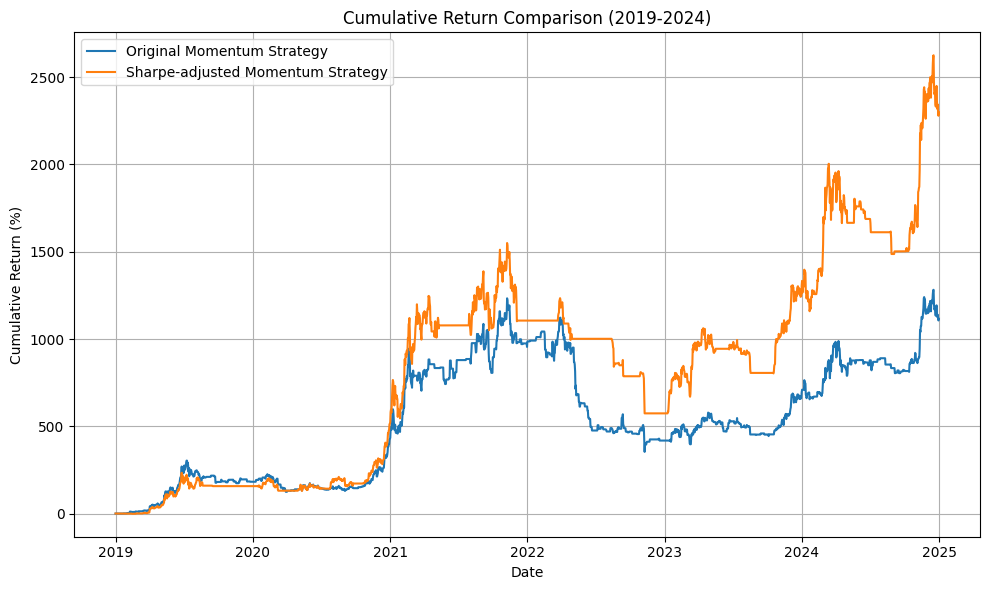

Original Strategy position ratio: 51.64%
Improved Strategy position ratio: 55.11%


In [11]:
# Q17
# -----------------------------
# Step 1: Load and preprocess data
# -----------------------------
df = pd.read_excel(file_path, sheet_name='Cryptos')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Calculate BTC simple daily returns
df['return'] = df['BTC'].pct_change()
df.dropna(subset=['return'], inplace=True)
df.reset_index(drop=True, inplace=True)

# -----------------------------
# Step 2: Define AR(2) model forecast function
# -----------------------------
def forecast_ar2(returns_60):
    """
    Using past 60 days of returns, fit an AR(2) model with OLS:
        r_t = c + φ1*r_(t-1) + φ2*r_(t-2) + ε_t
    and use the last two days' returns to predict the next day's return.
    """
    r = np.array(returns_60)
    y = r[2:]
    X = np.column_stack([np.ones(len(y)), r[1:-1], r[:-2]])
    coef = np.linalg.lstsq(X, y, rcond=None)[0]
    return coef[0] + coef[1]*r[-1] + coef[2]*r[-2]

# -----------------------------
# Step 3: Initialize relevant columns
# -----------------------------
df['Forecast'] = np.nan           # AR(2) forecast value
df['Avg360'] = np.nan             # 360-day average return
df['StrategyReturn_Original'] = 0.0
df['SharpeSignal'] = np.nan
df['StrategyReturn_Improved'] = 0.0

# -----------------------------
# Step 4: Calculate daily forecasts & strategy signals (avoiding look-ahead bias)
# -----------------------------
# We start from i=361: because we need to use previous day (i-1) data for prediction,
# and need (i-1) - 360 >= 0 to have enough historical window
for i in range(361, len(df)):
    # Trading decision for day i is based on the prediction made on "day i-1"
    forecast_day = i - 1

    # Past 60 days: for AR(2); window is [forecast_day-60, forecast_day-1]
    start_60 = forecast_day - 60
    end_60 = forecast_day - 1
    window_60 = df.loc[start_60:end_60, 'return'].values
    if len(window_60) < 60:
        continue

    # Past 360 days: for average return r_bar; window is [forecast_day-360, forecast_day-1]
    start_360 = forecast_day - 360
    end_360 = forecast_day - 1
    window_360 = df.loc[start_360:end_360, 'return'].values
    if len(window_360) < 360:
        continue

    # Calculate AR(2) forecast value & 360-day average return
    fcast = forecast_ar2(window_60)
    r_bar = window_360.mean()

    # Store forecast value and average return in day i (for reference)
    df.at[i, 'Forecast'] = fcast
    df.at[i, 'Avg360'] = r_bar

    # -----------------------------
    # 4.1 Original strategy: fixed threshold max(0, r_bar)
    # -----------------------------
    threshold_orig = max(0, r_bar)
    if fcast > threshold_orig:
        # If buy condition is met, return for day i = actual return, otherwise 0
        df.at[i, 'StrategyReturn_Original'] = df.loc[i, 'return']
    else:
        df.at[i, 'StrategyReturn_Original'] = 0.0

    # -----------------------------
    # 4.2 Improved strategy: Sharpe-like signal + fixed threshold
    # -----------------------------
    mu_60 = window_60.mean()
    sigma_60 = window_60.std()
    if sigma_60 == 0:
        sharpe_like = 0
    else:
        sharpe_like = mu_60 / sigma_60

    df.at[i, 'SharpeSignal'] = sharpe_like

    # Set a lower threshold to prevent excessive position taking
    threshold_improved = 0.03
    if sharpe_like > threshold_improved:
        df.at[i, 'StrategyReturn_Improved'] = df.loc[i, 'return']
    else:
        df.at[i, 'StrategyReturn_Improved'] = 0.0

# -----------------------------
# Step 5: Filter 2019-2024 data and calculate cumulative returns
# -----------------------------
df['Year'] = df['Date'].dt.year
df_strategy = df[(df['Year'] >= 2019) & (df['Year'] <= 2024)].copy()

df_strategy['CumulativeReturn_Original'] = (1 + df_strategy['StrategyReturn_Original']).cumprod() - 1
df_strategy['CumulativeReturn_Improved'] = (1 + df_strategy['StrategyReturn_Improved']).cumprod() - 1

# -----------------------------
# Step 6: Visualization comparison
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(df_strategy['Date'], df_strategy['CumulativeReturn_Original']*100, label='Original Momentum Strategy')
plt.plot(df_strategy['Date'], df_strategy['CumulativeReturn_Improved']*100, label='Sharpe-adjusted Momentum Strategy')
plt.title("Cumulative Return Comparison (2019-2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Step 7: Check position ratio information (optional)
# -----------------------------
# Calculate position ratio
original_position_ratio = (df_strategy['StrategyReturn_Original'] != 0).mean()
improved_position_ratio = (df_strategy['StrategyReturn_Improved'] != 0).mean()
print(f"Original Strategy position ratio: {original_position_ratio:.2%}")
print(f"Improved Strategy position ratio: {improved_position_ratio:.2%}")